## Imports

In [29]:
%load_ext autoreload
%autoreload 2

from utils.prepare_data import prepare_short_data, prepare_full_data
from environment import Environment
from models.base_model import Base_model
from models.DQN import DQN

from datetime import timedelta, datetime
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from models.TD import ActorModel, CriticModel, ActorImprovedValue, CriticTD, critic_epoch, actor_epoch
import torch
from tqdm import tqdm
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Constants

In [2]:
df = prepare_full_data('data/Data_RU.xlsx')

In [3]:
env = Environment(data=df[df.Date < datetime(2022, 2, 1)], stock_name='AFKS', initial_money=1000)
env.data.head()

,Date,Weekday,AFKS_close,AFKS_high,AFKS_low,AFKS_open,AFKS_volume,AFKS_D1,AFKS_D2,AFKS_D3,AFKS_D4
21,2018-02-01,3,12.265,12.265,12.105,12.140,10856600.0,0.011667,0.010297,0.010297,0.002891
22,2018-02-02,4,12.000,12.365,11.960,12.265,15760300.0,0.070244,-0.021606,0.008153,0.025502
24,2018-02-06,1,11.460,11.785,11.420,11.700,24278300.0,0.016949,-0.020513,0.007265,0.024518
26,2018-02-08,3,11.505,11.720,11.475,11.560,8508300.0,-0.061688,-0.004758,0.013841,0.007407
29,2018-02-13,1,12.320,12.715,12.250,12.660,19482300.0,0.033469,-0.026856,0.004344,0.033469


In [4]:
start_date = env.first_date()

## DQN

In [5]:
# 15 is random nummber in [10, days_count] here
dqn = DQN(env.observation_tensor(15).shape[0], 3, env, batch_size=32)
dqn.fit()

100%|██████████| 10000/10000 [02:24<00:00, 69.25it/s]


In [6]:
env.reset()
for i in range(10, env.day_count-1):
    obs = env.observation_tensor(i)
    action = dqn.predict(obs)
    
    reward = env.reward(i, action)
    state = env.observation_tensor(i)
#     model.fit(state, action, reward)
    
    env.transition(i, action)

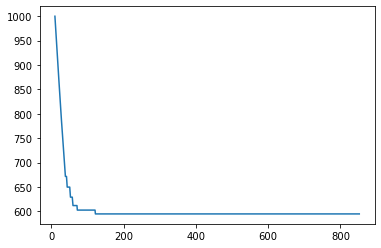

In [7]:
plt.plot(range(10, env.day_count), env.money)

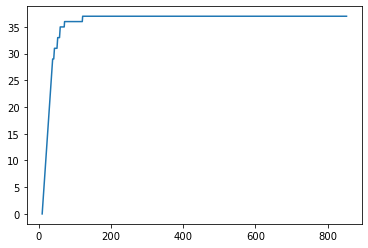

In [8]:
plt.plot(range(10, env.day_count), env.stocks)

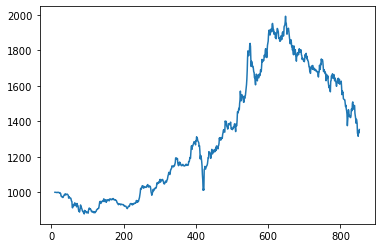

In [9]:
plt.plot(range(10, env.day_count), env.total_cost())

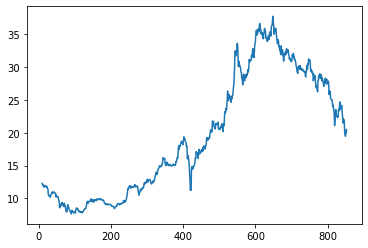

In [10]:
plt.plot(range(10, env.day_count), env.stock_cost())

### Add more stocks to train on

In [11]:
env = Environment(data=df, stock_name='AFKS', initial_money=1000)
dqn = DQN(env.observation_tensor(15).shape[0],
          3,
          env,
          batch_size=128)
for s in ['AFKS', 
          'SBER',
          'YNDX',
#           'GAZP'
         ]:
    state = dqn.state_dict()
    env = Environment(data=df, stock_name=s, initial_money=1000)
    dqn.fit(state)

100%|██████████| 10000/10000 [03:45<00:00, 44.33it/s]


## Testing

In [12]:
test_env = Environment(data=df, stock_name='SBER', initial_money=1000)
# test_env = Environment(data=df, stock_name='AFKS', initial_money=1000)

In [13]:
test_env.reset()
for i in range(10, test_env.day_count-1):
    obs = test_env.observation_tensor(i)
    action = dqn.predict(obs)
    
    reward = test_env.reward(i, action)
    state = test_env.observation_tensor(i)
#     model.fit(state, action, reward)
    
    test_env.transition(i, action)

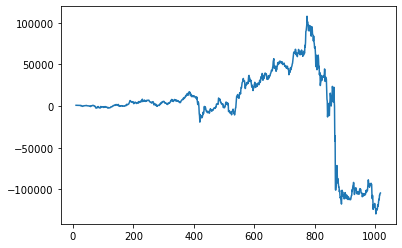

In [14]:
plt.plot(range(10, test_env.day_count), test_env.total_cost())

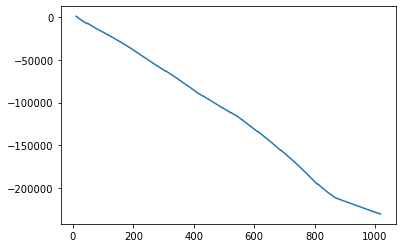

In [15]:
plt.plot(range(10, test_env.day_count), test_env.money)

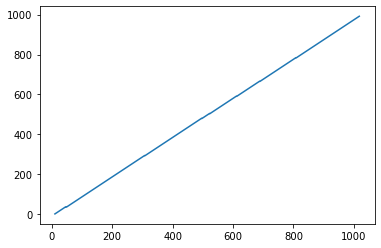

In [16]:
plt.plot(range(10, test_env.day_count), test_env.stocks)

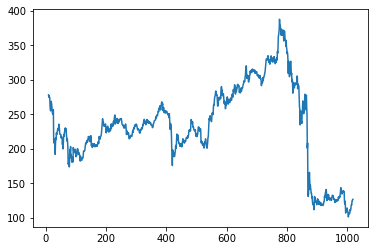

In [17]:
plt.plot(range(10, test_env.day_count), test_env.stock_cost())

## TD model

In [60]:
from models.TD import TD

In [61]:
model = TD(128, env, 100)

In [62]:
model.fit()

Actor-Critic learning:   0%|          | 0/5 [00:00<?, ?it/s]

Critic epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Critic mean loss: 46104016.0


Actor epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Actor mean value: -117.2208023071289


Critic epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Critic mean loss: 70112080.0


Actor epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Actor mean value: -186.4030303955078


Critic epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Critic mean loss: 63028912.0


Actor epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Actor mean value: -346.5693054199219


Critic epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Critic mean loss: 74727800.0


Actor epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Actor mean value: -88.81214904785156


Critic epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Critic mean loss: 67327944.0


Actor epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Actor mean value: -201.9898681640625


In [64]:
test_env = Environment(data=df, stock_name='SBER', initial_money=1000)

In [65]:
test_env.reset()
for i in range(10, test_env.day_count-1):
    obs = test_env.observation_tensor(i)
    action = model.predict(obs)
    
    reward = test_env.reward(i, action)
    state = test_env.observation_tensor(i)
    
    test_env.transition(i, action)

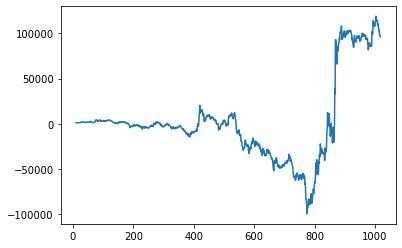

In [66]:
plt.plot(range(10, test_env.day_count), test_env.total_cost())

In [ ]:
plt.plot(range(10, test_env.day_count), test_env.money)

In [ ]:
plt.plot(range(10, test_env.day_count), test_env.stocks)

## RRT

In [67]:
from models.RRT import Random_trees

In [68]:
stocks_names = ['AMEZ', 'AQUA', 'VTBR']
env_dict ={}
for name in stocks_names:
    env_dict[name]=Environment(data=df, stock_name=name, initial_money=1000)

In [69]:
test_stock_name = 'BELU'
env = Environment(data=df, stock_name=test_stock_name, initial_money=1000)
env.reset()
day_count = 10
stocks_dict = env_dict
act_space = [-1, 0, 1]

model = Random_trees()
for i in range(10, 10+day_count):
    obs = env.observation_tensor(i)
    model.fit(stocks_dict, obs[-2:], obs[:-2], i)
    action_probas = model.predict(obs, i, stocks_dict)
    action = act_space[np.argmax(action_probas)]
    print(f' Probabilities for step {i}: action_probas, action: {action}')
    env.transition(action, i)

N processed points: 3


100%|██████████| 3/3 [00:00<00:00, 41.66it/s]


 Probabilities for step 10: action_probas, action: -1
N processed points: 6


100%|██████████| 6/6 [00:00<00:00, 60.67it/s]


 Probabilities for step 11: action_probas, action: -1
N processed points: 9


100%|██████████| 9/9 [00:00<00:00, 55.88it/s]


 Probabilities for step 12: action_probas, action: -1
N processed points: 12


100%|██████████| 12/12 [00:00<00:00, 61.20it/s]


 Probabilities for step 13: action_probas, action: -1
N processed points: 15


100%|██████████| 15/15 [00:00<00:00, 58.23it/s]


 Probabilities for step 14: action_probas, action: -1
N processed points: 18


100%|██████████| 18/18 [00:00<00:00, 51.35it/s]


 Probabilities for step 15: action_probas, action: -1
N processed points: 21


100%|██████████| 21/21 [00:00<00:00, 54.12it/s]


 Probabilities for step 16: action_probas, action: -1
N processed points: 24


100%|██████████| 24/24 [00:00<00:00, 61.53it/s]


 Probabilities for step 17: action_probas, action: -1
N processed points: 27


100%|██████████| 27/27 [00:00<00:00, 59.93it/s]


 Probabilities for step 18: action_probas, action: -1
N processed points: 30


100%|██████████| 30/30 [00:00<00:00, 59.99it/s]

 Probabilities for step 19: action_probas, action: -1


In [70]:
test_env = Environment(data=df, stock_name='SBER', initial_money=1000)

In [72]:
test_env.reset()
for i in range(10, test_env.day_count-1):
    obs = test_env.observation_tensor(i)
    action = model.predict(obs)
    
    reward = test_env.reward(i, action)
    state = test_env.observation_tensor(i)
    
    test_env.transition(i, action)

TypeError: predict() missing 2 required positional arguments: 'ind' and 'stocks_dict'